In [1]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as fn

In [2]:

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
# Correct Usage Example (pass ONLY the full file name):
#   file_name_to_load = get_training_filename("sms_spam.csv") # correct - pass ONLY the full file name  
#   
# Incorrect Usage Example
#   file_name_to_load = get_training_filename("/sms_spam.csv") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("sms_spam.csv/") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("c:/users/will/data/sms_spam.csv") incorrect -pass ONLY the full file name
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "dbfs:/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [3]:
train = spark.read.csv(get_training_filename('train.csv'), inferSchema=True, header=True)
test = spark.read.csv(get_training_filename('test.csv'), inferSchema=True, header=True)

In [4]:
train.toPandas().head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
test.toPandas().head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [6]:
print(train.toPandas().shape, test.toPandas().shape)

(381109, 12) (127037, 11)

In [7]:
# checking for NAs
train.select([fn.count(fn.when(fn.isnull(c) | fn.isnan(c), c)).alias(c) for c in train.columns]).show()

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
 id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+

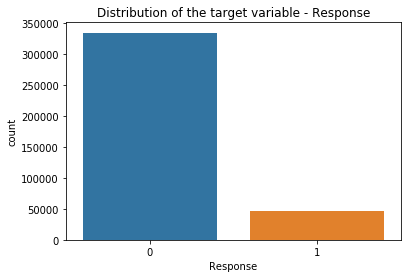

In [8]:
ax = sns.countplot(train.select('Response').toPandas()['Response'])
ax.set_title('Distribution of the target variable - Response')

Classes are heavily imbalanced.

Although <i>Region_Code</i> and <i>Policy_Sales_Channel</i> are categorical variables, for exploratory analysis, it is easier to treat them as numerical variables.

In [11]:
numerical_columns=['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
categorical_columns=['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response']

In [12]:
train[numerical_columns].describe().show()

+-------+------------------+------------------+------------------+--------------------+------------------+
summary| Age| Region_Code| Annual_Premium|Policy_Sales_Channel| Vintage|
+-------+------------------+------------------+------------------+--------------------+------------------+
 count| 381109| 381109| 381109| 381109| 381109|
 mean|38.822583565331705|26.388807401557035|30564.389581458323| 112.03429465061177|154.34739667654136|
 stddev|15.511611018095321|13.229888025788474|17213.155056980126| 54.20399477485638| 83.6713036265871|
 min| 20| 0.0| 2630.0| 1.0| 10|
 max| 85| 52.0| 540165.0| 163.0| 299|
+-------+------------------+------------------+------------------+--------------------+------------------+

Statistical summary observations -<br>
The min, mean and max values for each numerical variable are comparable, which reduces the possibility of erroneous data (the data is clean, no clear outliers).<br>
The scales of different variables are clearly different and scaling might be required for certain algorithms.

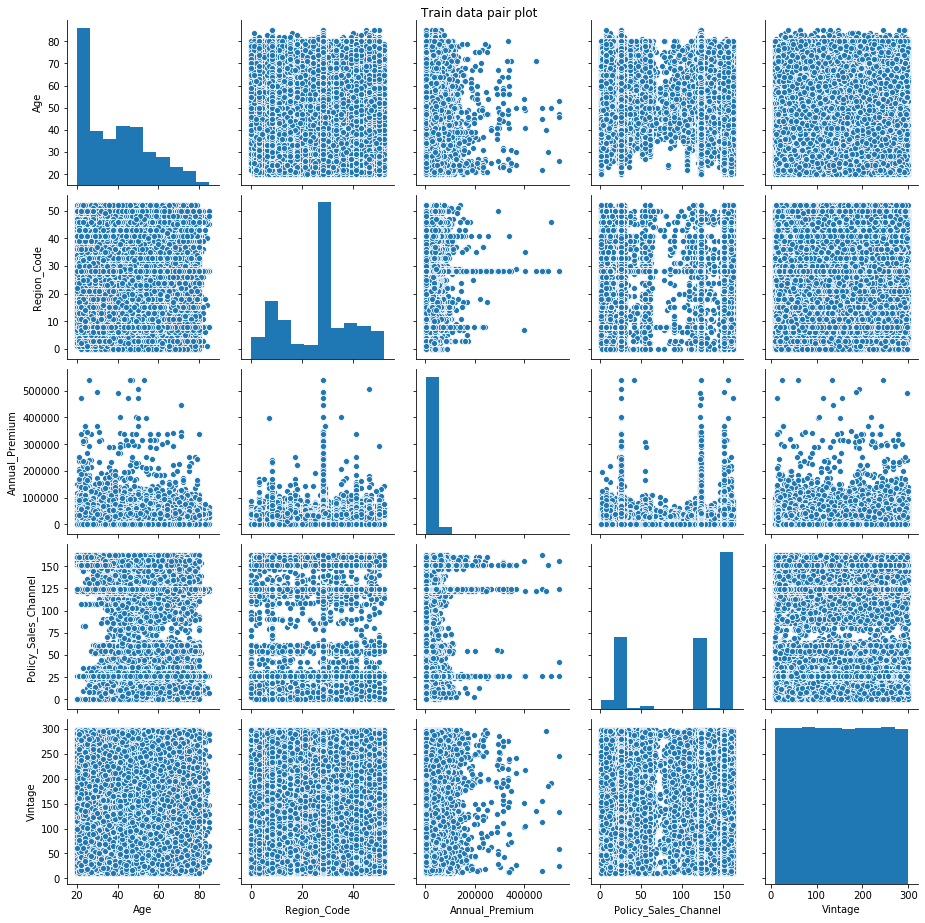

In [14]:
ax = sns.pairplot((train[numerical_columns]).toPandas())
ax.fig.suptitle('Train data pair plot', y=1.01)

Pair plot observations -<br>
There doesn't seem to be any correlation between the numerical variables.<br>
<i>Annual_Premium</i> is heavily left skewed.<br>
<i>Age</i> is left skewed.

In [16]:
# prints the counts of the categories in the column
def count_categorical(column):
  train.groupBy(column).count().show()

In [17]:
list(map(count_categorical, categorical_columns))

+------+------+
Gender| count|
+------+------+
Female|175020|
 Male|206089|
+------+------+

+---------------+------+
Driving_License| count|
+---------------+------+
 1|380297|
 0| 812|
+---------------+------+

+------------------+------+
Previously_Insured| count|
+------------------+------+
 1|174628|
 0|206481|
+------------------+------+

+-----------+------+
Vehicle_Age| count|
+-----------+------+
 > 2 Years| 16007|
 < 1 Year|164786|
 1-2 Year|200316|
+-----------+------+

+--------------+------+
Vehicle_Damage| count|
+--------------+------+
 No|188696|
 Yes|192413|
+--------------+------+

+--------+------+
Response| count|
+--------+------+
 1| 46710|
 0|334399|
+--------+------+

Out[78]: [None, None, None, None, None, None]

In [18]:
# plots the counts of the categories in the column with the target variable
def plot_categorical(column):
  plot_df = train.groupBy(column, 'Response').count().toPandas()
  ax = sns.catplot(x=column, y='count', col='Response', data=plot_df, kind='bar', height=4, aspect=.7)
  ax.fig.suptitle('Distribution of {} with Response'.format(column), y=1.01)

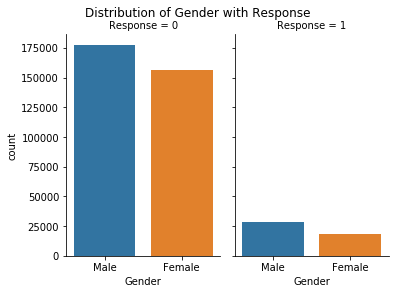

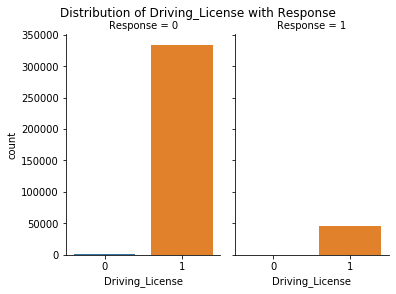

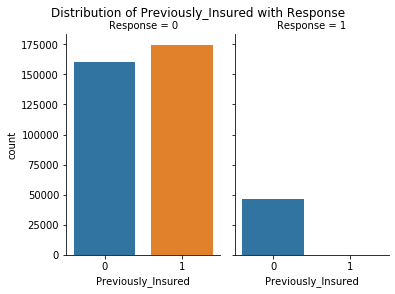

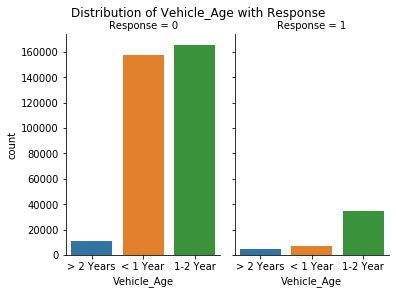

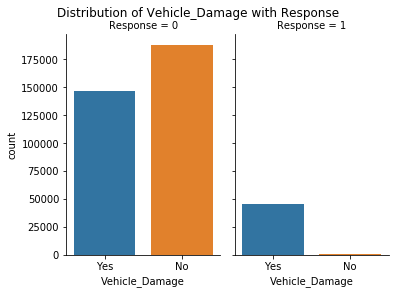

In [19]:
list(map(plot_categorical, categorical_columns[:-1]))

All interested customers (Response=1) have a driving license (Driving_License=1) and already have a vehicle insurance (Previously_Insured=1), and almost all of them have damaged their vehicle in the past (Vehicle_Damaged=Yes). These 3 columns have high predictive power.